This file is to create Set of Rules labels for our supervised learning.

## Import Data

In [ ]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
%matplotlib inline

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR="/content/drive/MyDrive/IAQF - Five+1 Guys/2022/Data"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%run "/content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/MLFramework.ipynb" import MLFramework

In [ ]:
os.getcwd()

'/content'

In [ ]:
!pip install --upgrade openpyxl

In [ ]:
df = pd.read_csv("Russell3000TootalReturn.csv", index_col=0)
df.index = pd.to_datetime(df.index)
df.tail(20)

,PX_LAST,PX_VOLUME,RET,RET10,SIG10,SR10
Date,,,,,,
2021-12-28,15444.68,8.372121e+08,-0.001920,-0.017243,0.008291,-10.398293
2021-12-29,15464.23,8.387725e+08,0.001266,-0.017023,0.008301,-10.254006
2021-12-30,15433.34,8.701014e+08,-0.001998,-0.029171,0.009218,-15.822841
2021-12-31,15391.17,9.716552e+08,-0.002732,-0.026044,0.009281,-14.030493
2022-01-03,15484.00,1.245747e+09,0.006031,-0.050904,0.010141,-25.097390
2022-01-04,15459.98,1.360014e+09,-0.001551,-0.059040,0.010164,-29.044696
2022-01-05,15123.88,1.481909e+09,-0.021740,-0.049311,0.008843,-27.881568
2022-01-06,15124.08,1.323434e+09,0.000013,-0.067767,0.009707,-34.907146
2022-01-07,15051.41,1.281492e+09,-0.004805,-0.058343,0.010447,-27.923472


In [ ]:
data = df[df.index>"2000-01-01"].fillna(method="ffill")
data.head(15)

,PX_LAST,PX_VOLUME,RET,RET10,SIG10,SR10
Date,,,,,,
2000-01-03,2909.89,1.748611e+09,-0.009045,0.007478,0.020033,1.866374
2000-01-04,2795.36,1.805332e+09,-0.039359,0.052923,0.014184,18.656401
2000-01-05,2802.51,2.100967e+09,0.002558,0.045370,0.014514,15.629273
2000-01-06,2784.07,1.972651e+09,-0.006580,0.051195,0.014144,18.097667
2000-01-07,2878.11,2.151953e+09,0.033778,-0.009656,0.013294,-3.631671
2000-01-10,2922.51,1.978201e+09,0.015427,-0.020349,0.012206,-8.335605
2000-01-11,2878.19,1.959800e+09,-0.015165,-0.009225,0.011346,-4.064938
2000-01-12,2867.89,1.855517e+09,-0.003579,-0.009219,0.011346,-4.062685
2000-01-13,2913.18,1.788324e+09,0.015792,-0.049839,0.012165,-20.484020


## Split train/test set

In [ ]:
def train_test_split(df, date='2018-01-01'):
  df_train = df[df.index < date]
  df_test = df[df.index > date]
  return df_train, df_test

df_train, df_test = train_test_split(data)

# Method 1: Horizon: detect an increase/decrease of at least r% in a future horizon of n units time.  
Let up=0.1, and down=-0.14. Look ahead 10 days.

In [ ]:
def sig(value, up, down):
  if value > up:
    return 1
  elif value < down:
    return -1

up = 0.02
down = -0.02
data['POS'] = np.nan
data['POS'] = data['RET10'].apply(sig, args=(up, down,)).fillna(method='ffill').fillna(0)
data

,PX_LAST,PX_VOLUME,RET,RET10,SIG10,SR10,POS_RET,POS_SR,State3,POS
Date,,,,,,,,,,
2000-01-03,2909.89,1.748611e+09,-0.009045,0.007478,0.020033,1.866374,0.0,0.0,-1.0,0.0
2000-01-04,2795.36,1.805332e+09,-0.039359,0.052923,0.014184,18.656401,1.0,1.0,1.0,1.0
2000-01-05,2802.51,2.100967e+09,0.002558,0.045370,0.014514,15.629273,1.0,1.0,1.0,1.0
2000-01-06,2784.07,1.972651e+09,-0.006580,0.051195,0.014144,18.097667,1.0,1.0,1.0,1.0
2000-01-07,2878.11,2.151953e+09,0.033778,-0.009656,0.013294,-3.631671,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2022-01-19,14547.22,1.322548e+09,-0.010110,-0.069665,0.010564,-32.974359,-1.0,-1.0,-1.0,-1.0
2022-01-20,14378.11,1.355285e+09,-0.011625,-0.069665,0.010564,-32.974359,-1.0,-1.0,-1.0,-1.0
2022-01-21,14099.17,1.917342e+09,-0.019400,-0.069665,0.010564,-32.974359,-1.0,-1.0,-1.0,-1.0


## 1.1 Horizon: ret limit

In [ ]:
def sig(value, up, down, mid):
  if value > up:
    return 1
  elif value < down:
    return -1
  elif (value>-mid) and (value<mid):
    return 0

up = 0.02
down = -0.02
mid = 0.001
data['POS_RET'] = np.nan
data['POS_RET'] = data['RET10'].apply(sig, args=(up, down, mid,)).fillna(method='ffill').fillna(0)
data

,PX_LAST,PX_VOLUME,RET,RET10,SIG10,SR10,POS_RET
Date,,,,,,,
2000-01-03,2909.89,1.748611e+09,-0.009045,0.007478,0.020033,1.866374,0.0
2000-01-04,2795.36,1.805332e+09,-0.039359,0.052923,0.014184,18.656401,1.0
2000-01-05,2802.51,2.100967e+09,0.002558,0.045370,0.014514,15.629273,1.0
2000-01-06,2784.07,1.972651e+09,-0.006580,0.051195,0.014144,18.097667,1.0
2000-01-07,2878.11,2.151953e+09,0.033778,-0.009656,0.013294,-3.631671,1.0
...,...,...,...,...,...,...,...
2022-01-19,14547.22,1.322548e+09,-0.010110,-0.069665,0.010564,-32.974359,-1.0
2022-01-20,14378.11,1.355285e+09,-0.011625,-0.069665,0.010564,-32.974359,-1.0
2022-01-21,14099.17,1.917342e+09,-0.019400,-0.069665,0.010564,-32.974359,-1.0


In [ ]:
df_train, df_test = train_test_split(data)

In [ ]:
def plot_bullbear(df, label_name):
  # create figure and axis objects with subplots()
  fig,ax = plt.subplots(figsize=(20,12))
  # make a plot
  ax.plot(df['PX_LAST'], color="red", marker="o")
  # set x-axis label
  ax.set_xlabel("year",fontsize=14)
  # set y-axis label
  ax.set_ylabel("Close",color="red",fontsize=14)

  # twin object for two different y-axis on the sample plot
  ax2=ax.twinx()
  # make a plot with different y-axis using second axis object
  ax2.plot(df[label_name], color="blue",marker="o")
  ax2.set_ylabel(label_name,color="blue",fontsize=14)
  plt.show()

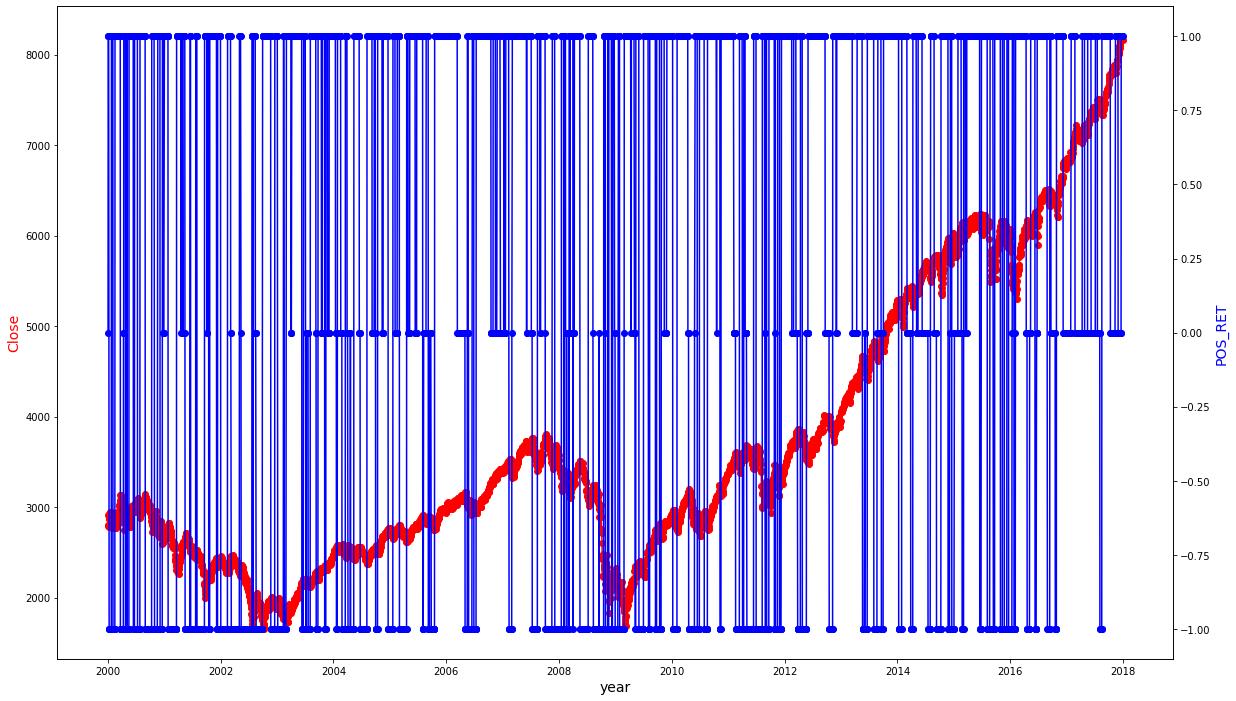

In [ ]:
plot_bullbear(df_train, "POS_RET")

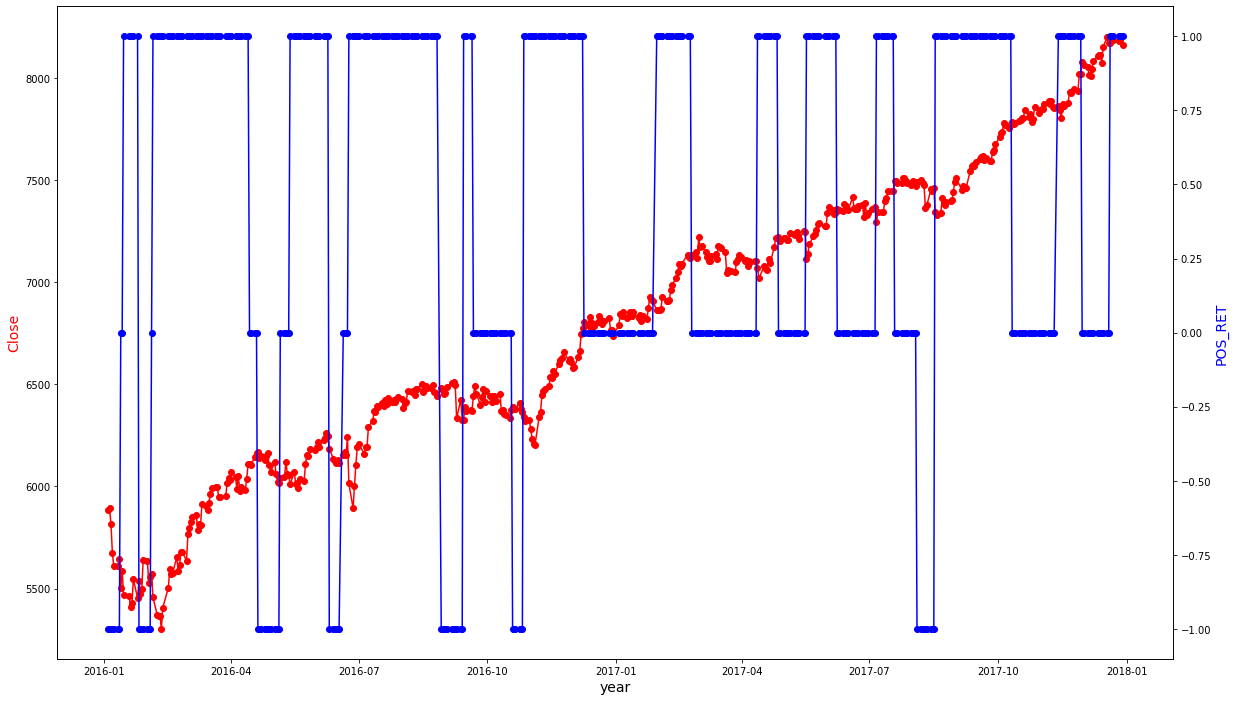

In [ ]:
plot_bullbear(df_train[df_train.index>'2016-01-01'], "POS_RET")

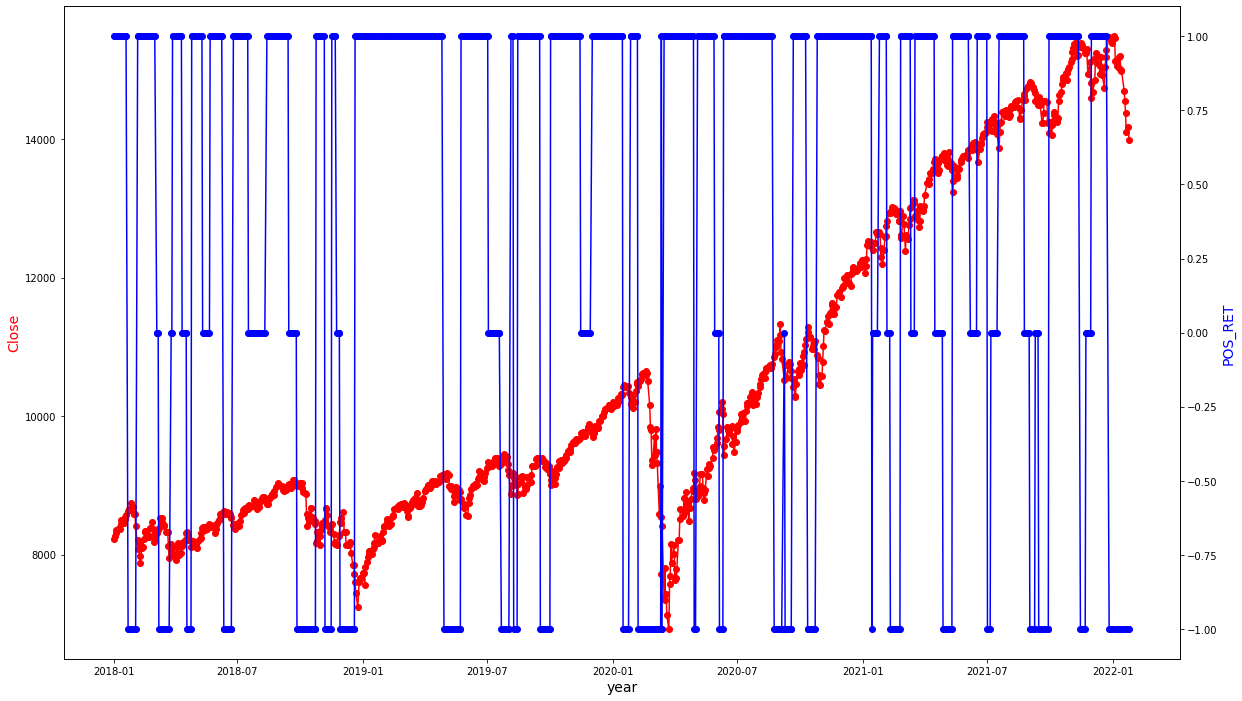

In [ ]:
plot_bullbear(df_test, "POS_RET")

problem: duration too short. state changes frequently. good or not?

## 1.2. Horizon: sharpe ratio limit

In [ ]:
up = 14
down = -6
mid = 2
data['POS_SR'] = np.nan
data['POS_SR'] = data['SR10'].apply(sig, args=(up, down, mid,)).fillna(method='ffill')
data

,PX_LAST,PX_VOLUME,RET,RET10,SIG10,SR10,POS_RET,POS_SR
Date,,,,,,,,
2000-01-03,2909.89,1.748611e+09,-0.009045,0.007478,0.020033,1.866374,0.0,0.0
2000-01-04,2795.36,1.805332e+09,-0.039359,0.052923,0.014184,18.656401,1.0,1.0
2000-01-05,2802.51,2.100967e+09,0.002558,0.045370,0.014514,15.629273,1.0,1.0
2000-01-06,2784.07,1.972651e+09,-0.006580,0.051195,0.014144,18.097667,1.0,1.0
2000-01-07,2878.11,2.151953e+09,0.033778,-0.009656,0.013294,-3.631671,1.0,1.0
...,...,...,...,...,...,...,...,...
2022-01-19,14547.22,1.322548e+09,-0.010110,-0.069665,0.010564,-32.974359,-1.0,-1.0
2022-01-20,14378.11,1.355285e+09,-0.011625,-0.069665,0.010564,-32.974359,-1.0,-1.0
2022-01-21,14099.17,1.917342e+09,-0.019400,-0.069665,0.010564,-32.974359,-1.0,-1.0


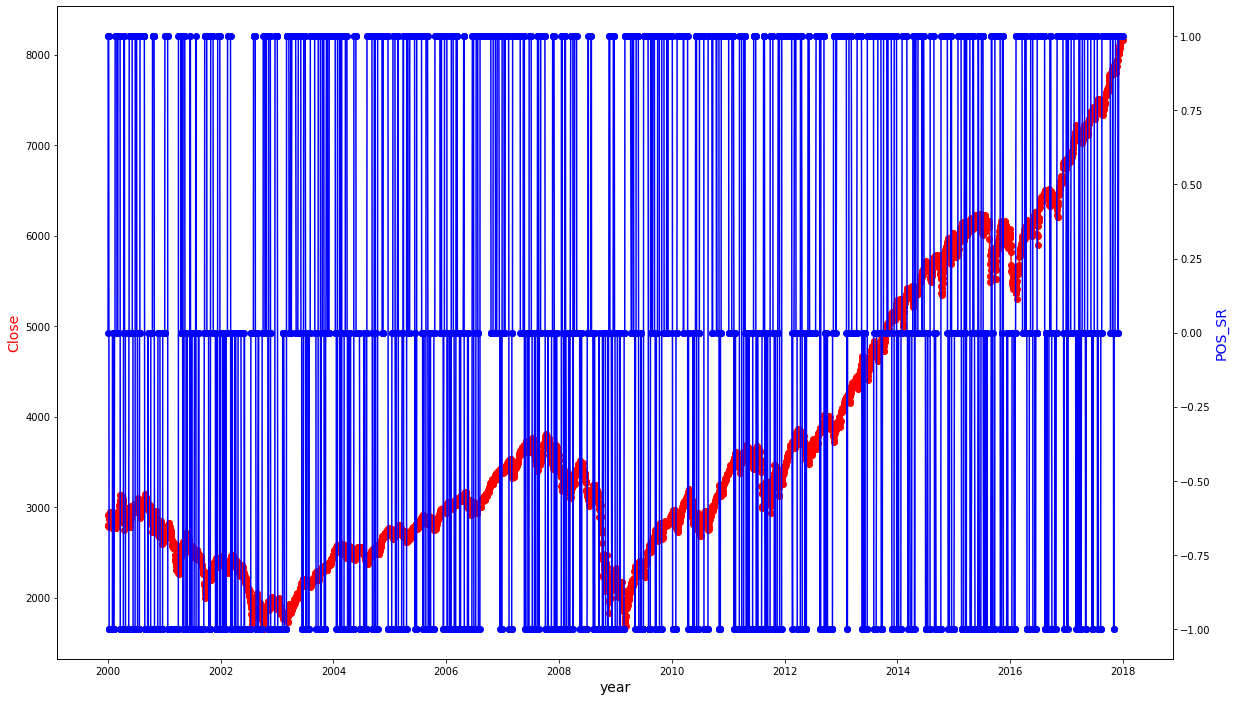

In [ ]:
plot_bullbear(df_train, "POS_SR")

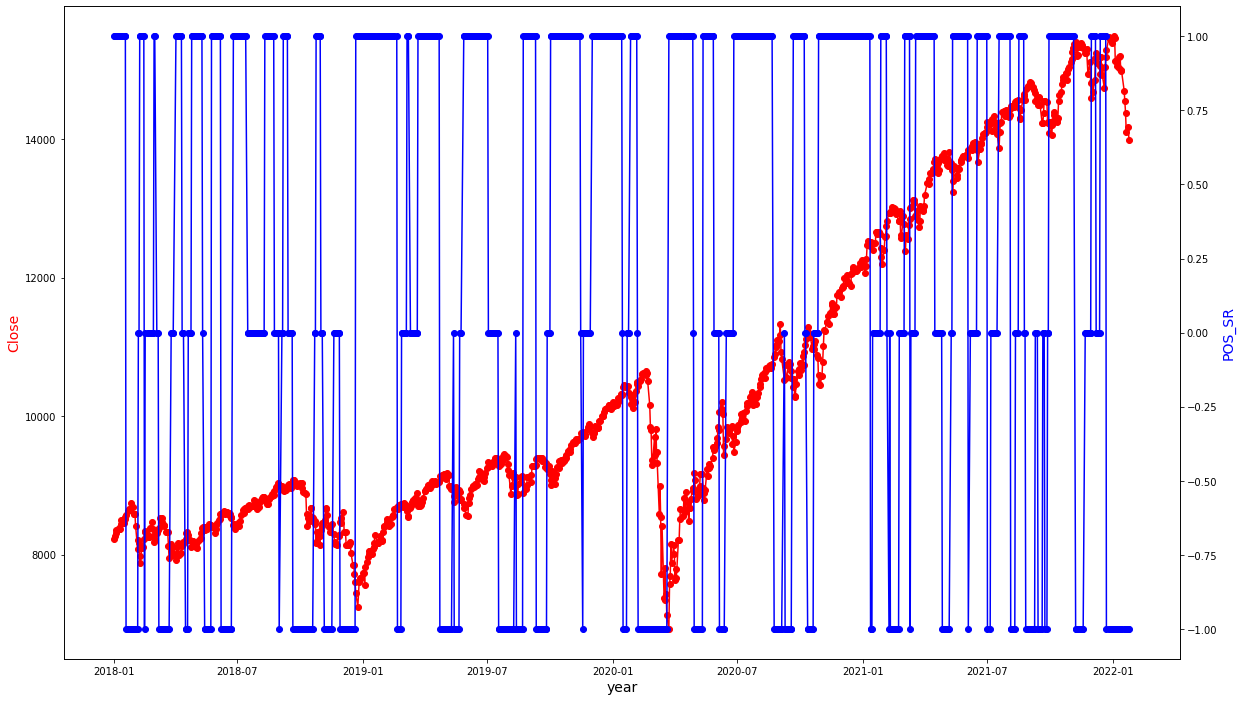

In [ ]:
plot_bullbear(df_test, "POS_SR")

similar to that of ret limit

# Method 2: LT: Lunde and Timmermann  
two states  
if we want to split them into 3 states, we can treat the third case as 0.


In [ ]:
def defbullbear(df, varname, labelname, lambda1, lambda2):
  peaks = [df.index[0]]
  troughs = [df.index[0]]
  flag = 1  # record latest bull/bear
  for i in range(df.shape[0]):
    if flag == 1:
      if df.iloc[i][varname] > df.loc[peaks[-1]][varname]:
        peaks[-1] = df.index[i]
      elif df.iloc[i][varname] < (1 - lambda2) * df.loc[peaks[-1]][varname]:
        troughs.append(df.index[i])
        flag = -1
    else:
      if df.iloc[i][varname] < df.loc[troughs[-1]][varname]:
        troughs[-1] = df.index[i]
      elif df.iloc[i][varname] > (1 + lambda1) * df.loc[troughs[-1]][varname]:
        peaks.append(df.index[i])
        flag = 1
  df[labelname] = np.nan
  df.loc[peaks, labelname] = 1
  df.loc[troughs, labelname] = -1
  df.fillna(method="bfill", inplace=True)
  return df

In [ ]:
df_train = defbullbear(df_train, "PX_LAST", "State3", 0.1, 0.05)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

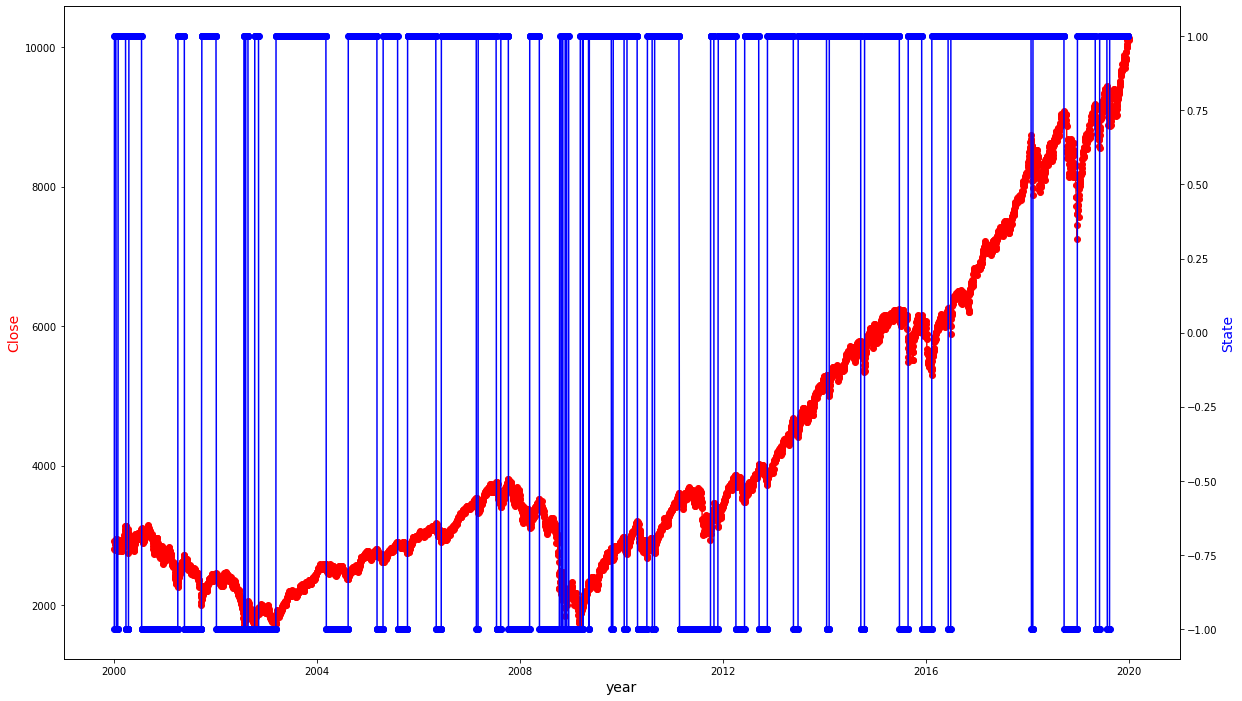

In [ ]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(20,12))
# make a plot
ax.plot(df_train['PX_LAST'], color="red", marker="o")
# set x-axis label
ax.set_xlabel("year",fontsize=14)
# set y-axis label
ax.set_ylabel("Close",color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df_train["State"], color="blue",marker="o")
ax2.set_ylabel("State",color="blue",fontsize=14)
plt.show()

## 2.1. LT: ret limit

In [ ]:
def defbullbear3(df, varname, limitname, labelname, lambda1, lambda2, lambda3): 
  # limit: ret, sharpe ratio
  # lambda1: up, lambda2: down, lambda3: mid
  peaks = [df.index[0]]
  troughs = [df.index[0]]
  statics = []
  flag = 1  # record latest bull/bear
  for i in range(df.shape[0]):
    if flag == 1:
      if df.iloc[i][varname] > df.loc[peaks[-1]][varname]:
        peaks.append(df.index[i])
      elif df.iloc[i][varname] < (1 - lambda2) * df.loc[peaks[-1]][varname]:
        troughs.append(df.index[i])
        flag = -1
      elif (df.iloc[i][limitname] > -lambda3) and (df.iloc[i][limitname] < lambda3):
        statics.append(df.index[i])
    else:
      if df.iloc[i][varname] < df.loc[troughs[-1]][varname]:
        troughs.append(df.index[i])
      elif df.iloc[i][varname] > (1 + lambda1) * df.loc[troughs[-1]][varname]:
        peaks.append(df.index[i])
        flag = 1
      elif (df.iloc[i][limitname] > -lambda3) and (df.iloc[i][limitname] < lambda3):
        statics.append(df.index[i])
  df[labelname] = np.nan
  df.loc[peaks, labelname] = 1
  df.loc[troughs, labelname] = -1
  df.loc[statics, labelname] = 0
  df.fillna(method="bfill", inplace=True)
  return df

In [ ]:
data = defbullbear3(data, "PX_LAST", "RET10", "State_RET", 0.1, 0.05, 0.005)
data

,PX_LAST,PX_VOLUME,RET,RET10,SIG10,SR10,POS_RET,POS_SR,State_RET
Date,,,,,,,,,
2000-01-03,2909.89,1.748611e+09,-0.009045,0.007478,0.020033,1.866374,0.0,0.0,-1.0
2000-01-04,2795.36,1.805332e+09,-0.039359,0.052923,0.014184,18.656401,1.0,1.0,1.0
2000-01-05,2802.51,2.100967e+09,0.002558,0.045370,0.014514,15.629273,1.0,1.0,1.0
2000-01-06,2784.07,1.972651e+09,-0.006580,0.051195,0.014144,18.097667,1.0,1.0,1.0
2000-01-07,2878.11,2.151953e+09,0.033778,-0.009656,0.013294,-3.631671,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
2022-01-19,14547.22,1.322548e+09,-0.010110,-0.069665,0.010564,-32.974359,-1.0,-1.0,-1.0
2022-01-20,14378.11,1.355285e+09,-0.011625,-0.069665,0.010564,-32.974359,-1.0,-1.0,-1.0
2022-01-21,14099.17,1.917342e+09,-0.019400,-0.069665,0.010564,-32.974359,-1.0,-1.0,-1.0


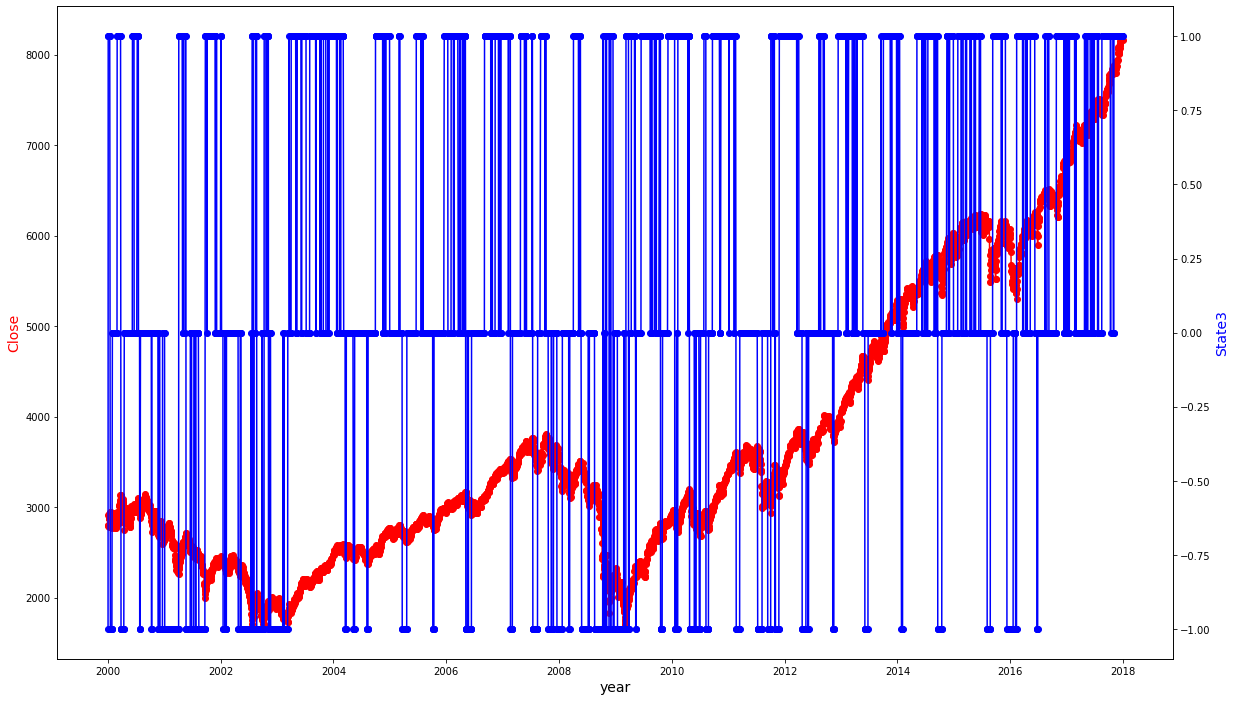

In [ ]:
df_train, df_test = train_test_split(data)
plot_bullbear(df_train, "State3")

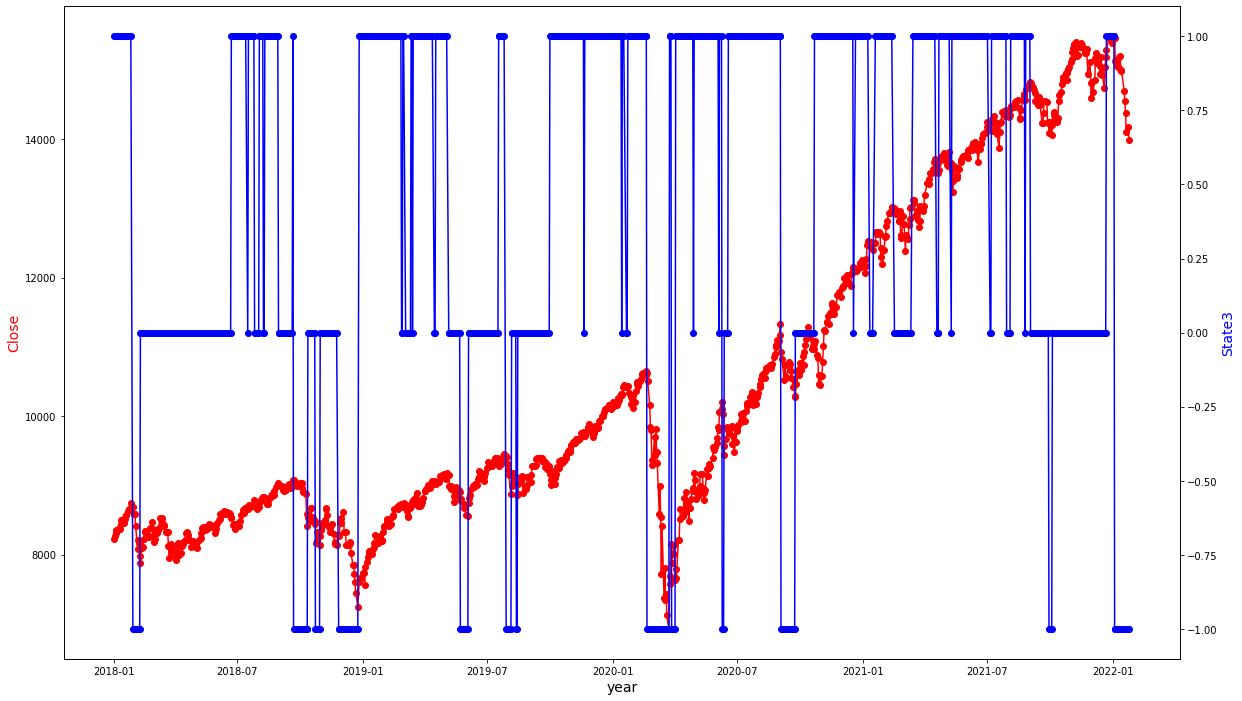

In [ ]:
plot_bullbear(df_test, "State3")

## 2.2 LT: Sharpe Ratio Limit

In [ ]:
data = defbullbear3(data, "PX_LAST", "SR10", "State_SR", 0.1, 0.05, 1)
data

,PX_LAST,PX_VOLUME,RET,RET10,SIG10,SR10,POS_RET,POS_SR,State_RET,State_SR
Date,,,,,,,,,,
2000-01-03,2909.89,1.748611e+09,-0.009045,0.007478,0.020033,1.866374,0.0,0.0,-1.0,-1.0
2000-01-04,2795.36,1.805332e+09,-0.039359,0.052923,0.014184,18.656401,1.0,1.0,1.0,1.0
2000-01-05,2802.51,2.100967e+09,0.002558,0.045370,0.014514,15.629273,1.0,1.0,1.0,1.0
2000-01-06,2784.07,1.972651e+09,-0.006580,0.051195,0.014144,18.097667,1.0,1.0,1.0,1.0
2000-01-07,2878.11,2.151953e+09,0.033778,-0.009656,0.013294,-3.631671,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2022-01-19,14547.22,1.322548e+09,-0.010110,-0.069665,0.010564,-32.974359,-1.0,-1.0,-1.0,-1.0
2022-01-20,14378.11,1.355285e+09,-0.011625,-0.069665,0.010564,-32.974359,-1.0,-1.0,-1.0,-1.0
2022-01-21,14099.17,1.917342e+09,-0.019400,-0.069665,0.010564,-32.974359,-1.0,-1.0,-1.0,-1.0


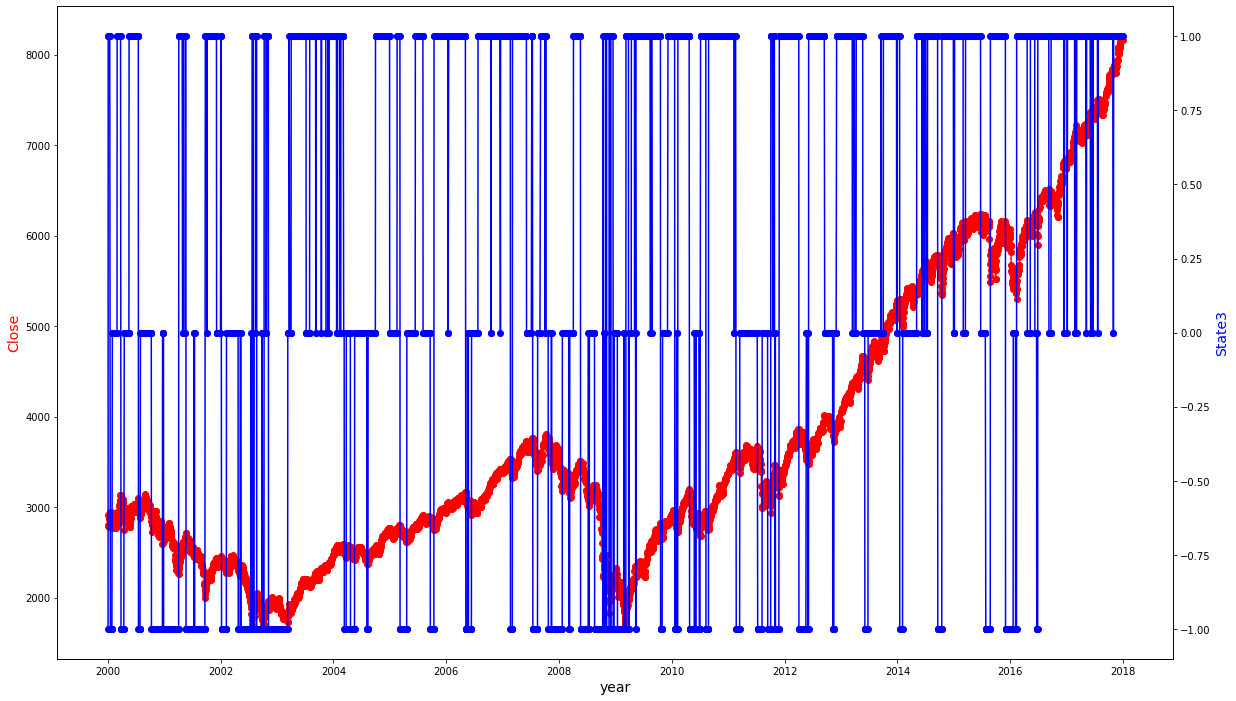

In [ ]:
df_train, df_test = train_test_split(data)
plot_bullbear(df_train, "State3")

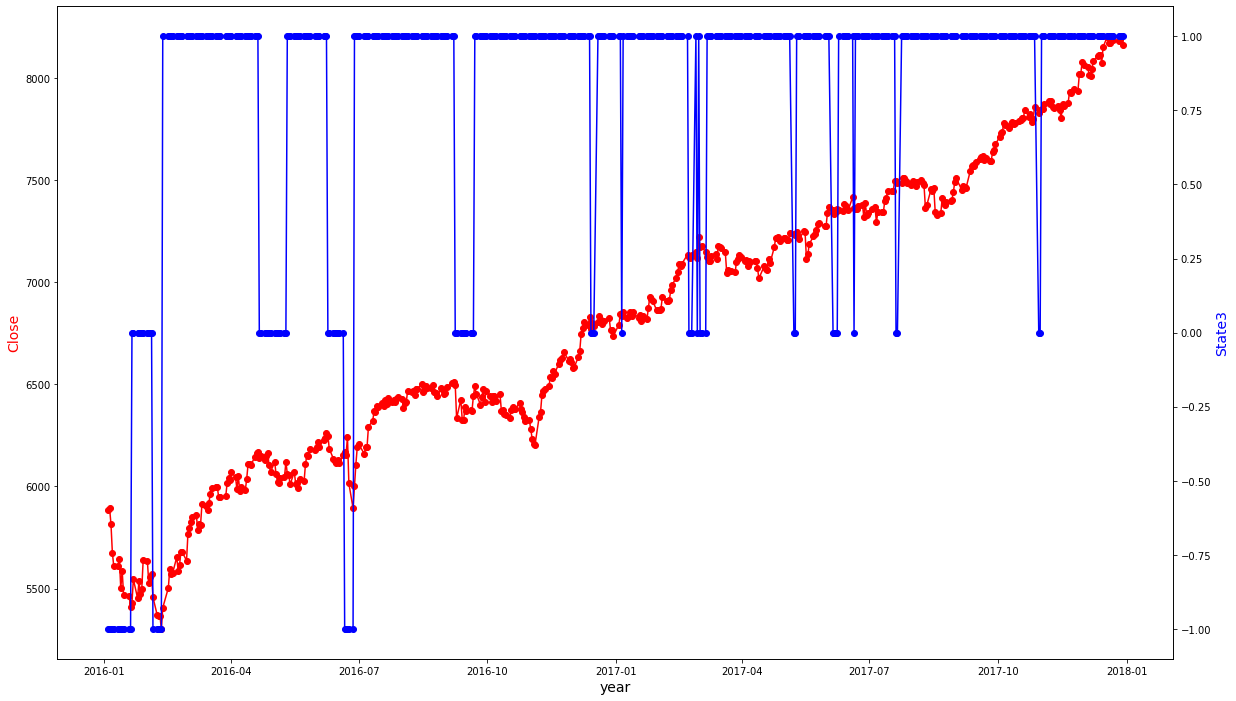

In [ ]:
plot_bullbear(df_train[df_train.index>'2016-01-01'], 'State3')

2016-12 should be bear

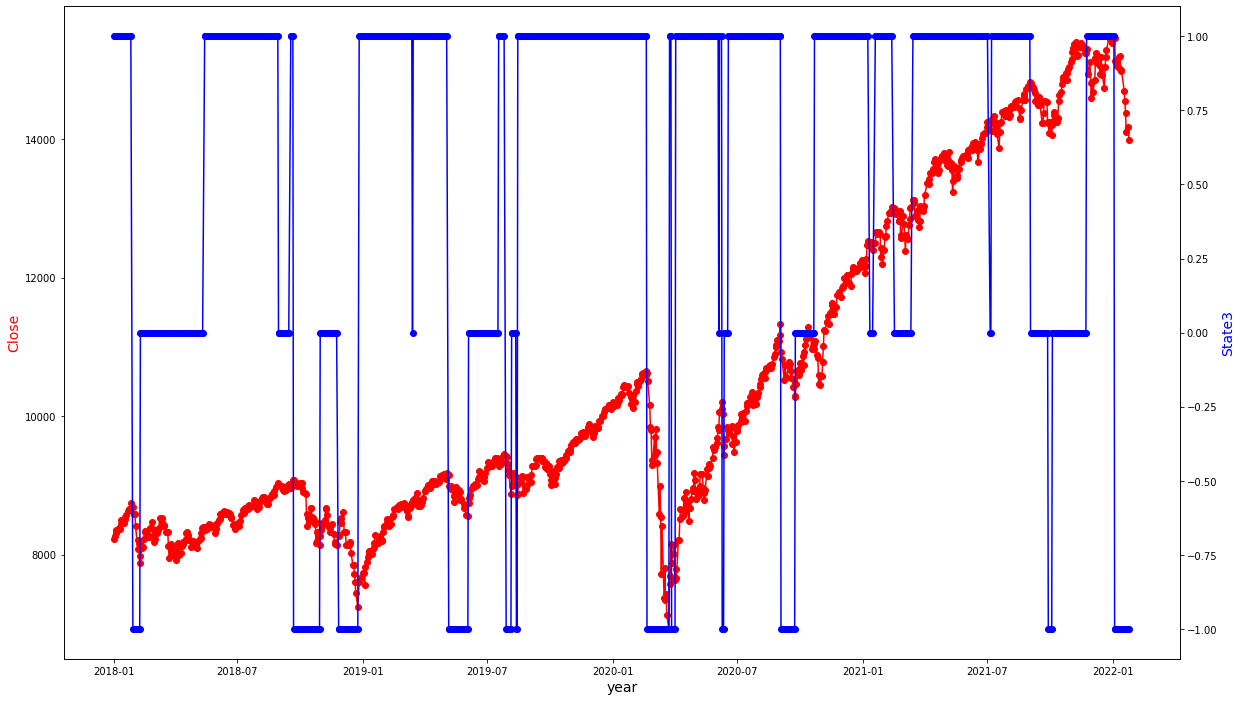

In [ ]:
plot_bullbear(df_test, "State3")

trading frequency: monthly

##2.3 Static State  
ret within a limit  
sharpe ratio in future 10 days  


In [ ]:
def defbullbear3(df, varname, limitname, lambda1, lambda2, lambda3): 
  # limit: ret, sharpe ratio
  # lambda1: up, lambda2: down, lambda3: mid
  peaks = [df.index[0]]
  troughs = [df.index[0]]
  statics = []
  flag = 1  # record latest bull/bear
  for i in range(df.shape[0]):
    if flag == 1:
      if df.iloc[i][varname] > df.loc[peaks[-1]][varname]:
        peaks.append(df.index[i])
      elif df.iloc[i][varname] < (1 - lambda2) * df.loc[peaks[-1]][varname]:
        troughs.append(df.index[i])
        flag = -1
      elif (df.iloc[i][limitname] > -lambda3) and (df.iloc[i][limitname] < lambda3):
        statics.append(df.index[i])
        flag = 0
    elif flag == -1:
      if df.iloc[i][varname] < df.loc[troughs[-1]][varname]:
        troughs.append(df.index[i])
      elif df.iloc[i][varname] > (1 + lambda1) * df.loc[troughs[-1]][varname]:
        peaks.append(df.index[i])
        flag = 1
      elif (df.iloc[i][limitname] > -lambda3) and (df.iloc[i][limitname] < lambda3):
        statics.append(df.index[i])
        flag = 0
    else:
      if df.iloc[i][varname] < (1 - lambda2) * df.loc[statics[-1]][varname]:
        troughs.append(df.index[i])
        flag = 0
      elif df.iloc[i][varname] > (1 + lambda1) * df.loc[troughs[-1]][varname]:
        peaks.append(df.index[i])
        flag = 1
      else:
        statics.append(df.index[i])

  df["State3"] = np.nan
  df.loc[peaks, "State3"] = 1
  df.loc[troughs, "State3"] = -1
  df.loc[statics, "State3"] = 0
  df.fillna(method="bfill", inplace=True)
  return df

In [ ]:
data = defbullbear3(data, "PX_LAST", "RET10", 0.1, 0.05, 0.001)

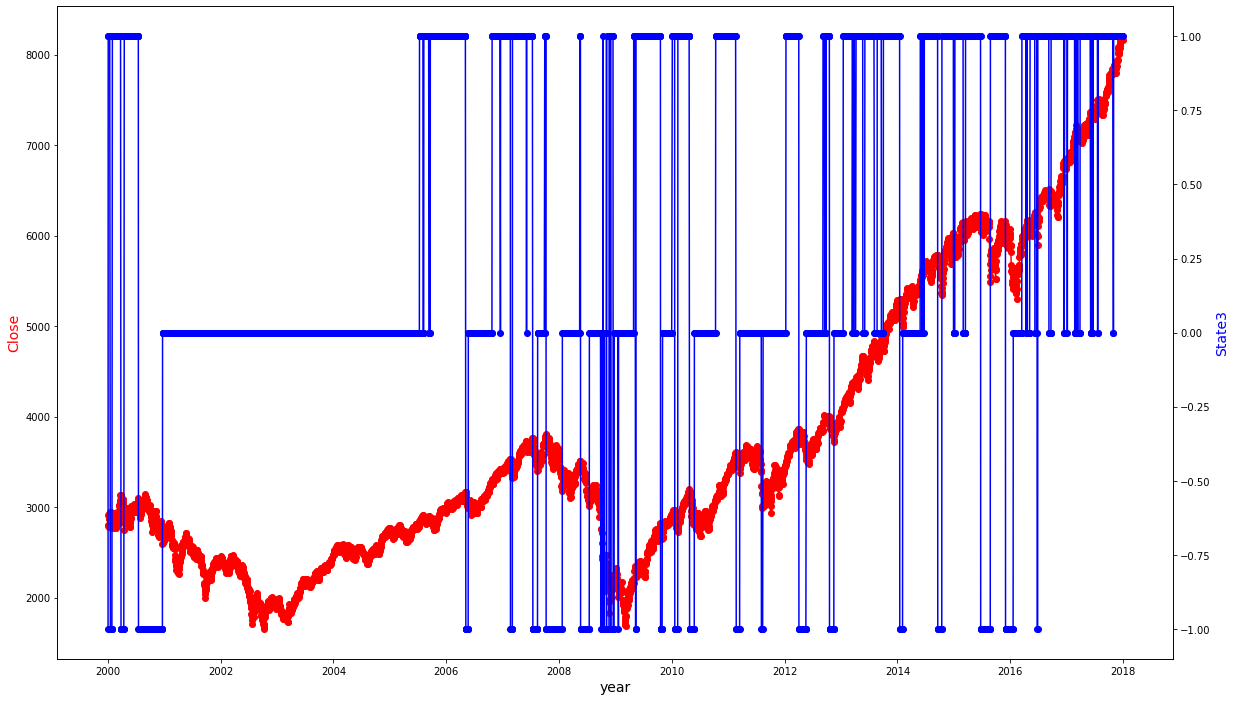

In [ ]:
df_train, df_test = train_test_split(data)
plot_bullbear(df_train, "State3")

Personally speaking, it is not good to set up too many rules.

# Save label to csv

parameters:  
POS_RET: up = 0.02
down = -0.02
mid = 0.001  
POS_SR: up = 14
down = -6
mid = 2  
State_RET: 0.1, 0.05, 0.005  
State_SR: 0.1, 0.05, 1

In [ ]:
data[['POS_RET','POS_SR','State_RET','State_SR']].corr()

,POS_RET,POS_SR,State_RET,State_SR
POS_RET,1.000000,0.761182,0.405984,0.467478
POS_SR,0.761182,1.000000,0.383939,0.407295
State_RET,0.405984,0.383939,1.000000,0.865239
State_SR,0.467478,0.407295,0.865239,1.000000


In [ ]:
data.to_csv(DATA_DIR + "/label.csv")

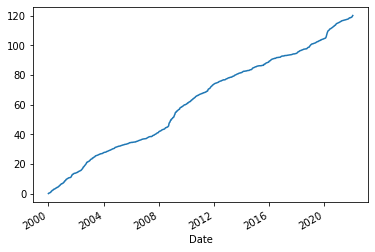

In [ ]:
data['RET10'].mul(data['POS_RET']).cumsum().plot()

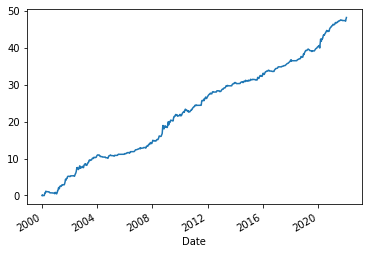

In [ ]:
data['RET10'].mul(data['State_RET']).cumsum().plot()